## 4.4 評価
2020-06-09   
上　予測結果　横　真値に戻す  
make_cm関数を追加  
2020-06-17  
pred関数追加

In [1]:
# 日本語化ライブラリ導入
!pip install japanize-matplotlib | tail -n 1

In [2]:
# 共通事前処理

# 余分なワーニングを非表示にする
import warnings
warnings.filterwarnings('ignore')

# 必要ライブラリのimport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# matplotlib日本語化対応
import japanize_matplotlib

# データフレーム表示用関数
from IPython.display import display

# 表示オプション調整
# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)
# numpyの浮動小数点の表示精度
np.set_printoptions(suppress=True, precision=4)
# データフレームでの表示精度
pd.options.display.float_format = '{:.4f}'.format
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14

# 乱数の種
random_seed = 123

### 4.4.1 混同行列

#### 混同行列

In [3]:
# (1)データ読み込みから(4)データ分割まで

# ライブラリのimport
from sklearn.datasets import load_breast_cancer

# データのロード
cancer = load_breast_cancer()

# 入力データ x
x = cancer.data

# 正解データ y
# 良性: 0 悪性: 1に値を変更する
y = 1- cancer.target

# 入力データを2次元に絞り込み
x2 = x[:,:2]

# (4) データ分割
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x2, y, 
    train_size=0.7, test_size=0.3, random_state=random_seed)

In [4]:
# (5)アルゴリズム選定から(8)評価まで

# (5) アルゴリズム選定 (ロジスティック回帰)
from sklearn.linear_model import LogisticRegression
algorism = LogisticRegression(random_state=random_seed)

# (6) 学習
algorism.fit(x_train, y_train)

# (7) 予測
y_pred = algorism.predict(x_test)

# (8) 評価
score = algorism.score(x_test, y_test)

# 結果確認
print(f'score: {score:.4f}')

score: 0.8772


In [5]:
# 混同行列の計算

# 必要ライブラリの取込み
from sklearn.metrics import confusion_matrix

# 混同行列の生成
#   y_test: 検証データの正解データ
#   y_pred: 検証データの予測結果
matrix = confusion_matrix(y_test, y_pred)

# 結果確認
print(matrix)

[[101   2]
 [ 19  49]]


In [6]:
# 混同行列表示用関数

def make_cm(matrix, columns):
    # matrix numpy配列
    
    # columns 項目名リスト
    n = len(columns)
    
    # '正解データ'をn回繰り返すリスト生成
    act = ['正解データ'] * n
    pred = ['予測結果'] * n
    
    #データフレーム生成
    cm = pd.DataFrame(matrix, 
        columns=[pred, columns], index=[act, columns])
    return cm

In [7]:
# make_cmを使った混同行列標示
cm = make_cm(matrix, ['良性', '悪性'])
display(cm)

予測結果    
         良性  悪性
正解データ 良性  101   2
    悪性   19  49

### 4.4.2 精度・適合率・再現

In [8]:
# 適合率・再現率・F値の計算

# ライブラリの取込み
from sklearn.metrics import precision_recall_fscore_support

# 適合率・再現率・F値の計算
precision, recall, fscore, _ = precision_recall_fscore_support(
    y_test, y_pred, average='binary')

# 結果の確認
print(f'適合率: {precision:.4f}')
print(f'再現率: {recall:.4f}')
print(f'F値:   {fscore:.4f}')

適合率: 0.9608
再現率: 0.7206
F値:   0.8235


### 4.4.3 確率値と閾値

In [9]:
# 確率値の取得
y_proba = algorism.predict_proba(x_test)
print(y_proba[10:20,:])

[[0.7889 0.2111]
 [0.0812 0.9188]
 [0.8383 0.1617]
 [0.9391 0.0609]
 [0.369  0.631 ]
 [0.9451 0.0549]
 [0.9399 0.0601]
 [0.9494 0.0506]
 [0.9617 0.0383]
 [0.9836 0.0164]]


In [10]:
# positive(1)の確率値の取得
y_proba1 = y_proba[:,1]

# 結果確認
print(y_pred[10:20])
print(y_proba1[10:20])

[0 1 0 0 1 0 0 0 0 0]
[0.2111 0.9188 0.1617 0.0609 0.631  0.0549 0.0601 0.0506 0.0383 0.0164]


In [11]:
# 閾値を変化させる
thres = 0.5
print((y_proba1[10:20] > thres).astype(int))

thres = 0.7
print((y_proba1[10:20] > thres).astype(int))

[0 1 0 0 1 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0]


In [12]:
# 閾値を変更した場合の予測関数の定義
def pred(algorism, x, thres):
    # 確率値の取得(行列)
    y_proba = algorism.predict_proba(x)
    
    # 予測結果1の確率値
    y_proba1 =  y_proba[:,1]
    
    # 予測結果1の確率値 > 閾値
    y_pred = (y_proba1 > thres).astype(int)
    return y_pred

In [13]:
# 閾値0.5で予測結果取得
pred_05 = pred(algorism, x_test, 0.5)

# 閾値0.7で予測結果取得
pred_07 = pred(algorism, x_test, 0.7)

# 結果確認
print(pred_05[10:20])
print(pred_07[10:20])

[0 1 0 0 1 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0]


### 4.4.4 PR曲線とROC曲線

#### PR曲線

In [14]:
# PR曲線用配列の生成

# ライブラリの導入
from sklearn.metrics import precision_recall_curve

# precision値, recall値と閾値の取得
precision, recall, thresholds = precision_recall_curve(
    y_test, y_proba1)

# 結果をDataFrameにする
df_pr = pd.DataFrame([thresholds, precision, recall]).T
df_pr.columns = ['閾値', '適合率', '再現率']

# 閾値 0.5の周辺を表示
display(df_pr[52:122:10])

,閾値,適合率,再現率
52,0.1473,0.7901,0.9412
62,0.2027,0.8310,0.8676
72,0.3371,0.9344,0.8382
82,0.5347,0.9608,0.7206
92,0.7763,0.9756,0.5882
102,0.9025,1.0000,0.4559
112,0.9829,1.0000,0.3088


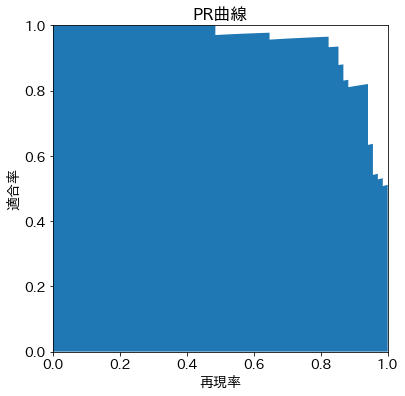

In [15]:
# PR曲線の描画

# 描画サイズ指定
plt.figure(figsize=(6,6))

# グラフ領域の塗りつぶし
plt.fill_between(recall, precision, 0)

# x, yの範囲指定
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# ラベル・タイトル表示
plt.xlabel('再現率')
plt.ylabel('適合率')
plt.title('PR曲線')
plt.show()

In [16]:
# PR曲線下面積の計算
from sklearn.metrics import auc
pr_auc = auc(recall, precision)
print(f'RP曲線下面積: {pr_auc:.4f}')

RP曲線下面積: 0.9459


#### ROC曲線

In [17]:
# ROC曲線用配列の生成

# ライブラリの導入
from sklearn.metrics import roc_curve

# 偽陽性値, 敏感度と閾値の取得

fpr, tpr, thresholds = roc_curve(
    y_test, y_proba1,drop_intermediate=False)

# 結果をDataFrameにする
df_roc = pd.DataFrame([thresholds, fpr, tpr]).T
df_roc.columns = ['閾値', '偽陽性率', '敏感度']

# 閾値 0.5の周辺を表示
display(df_roc[21:91:10])

,閾値,偽陽性率,敏感度
21,0.9829,0.0000,0.3088
31,0.9025,0.0000,0.4559
41,0.7763,0.0097,0.5882
51,0.5347,0.0194,0.7206
61,0.3371,0.0388,0.8382
71,0.2027,0.1165,0.8676
81,0.1473,0.1650,0.9412


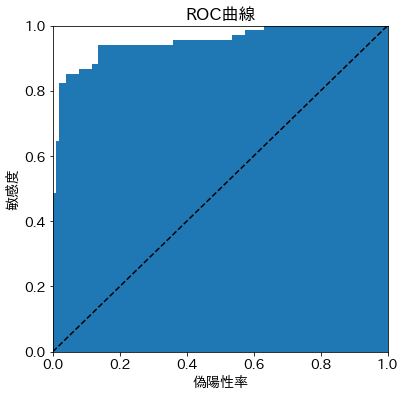

In [18]:
# ROC曲線の描画

# 描画サイズ指定
plt.figure(figsize=(6,6))

# 点線表示
plt.plot([0, 1], [0, 1], 'k--')

# グラフ領域の塗りつぶし
plt.fill_between(fpr, tpr, 0)

# x, yの範囲指定
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# ラベル・タイトル表示
plt.xlabel('偽陽性率')
plt.ylabel('敏感度')
plt.title('ROC曲線')
plt.show()

In [19]:
# ROC曲線下面積の計算
roc_auc = auc(fpr, tpr)
print(f'ROC曲線下面積:{roc_auc:.4f}')

ROC曲線下面積:0.9522


#### より精度のいいモデルでROCカーブを描画

In [20]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
  x, y, train_size=0.7, test_size=0.3, random_state=random_seed)
algorism = LogisticRegression()
algorism.fit(x_train, y_train)
y_pred = algorism.predict(x_test)
y_proba1 = algorism.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba1)

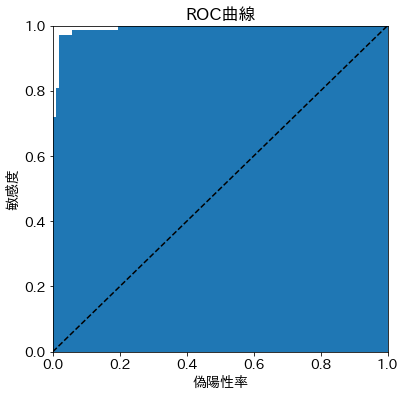

In [21]:
# ROC曲線の描画

plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.fill_between(fpr, tpr, 0)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('偽陽性率')
plt.ylabel('敏感度')
plt.title('ROC曲線')
plt.show()

In [22]:
# ROC AUCの計算
roc_auc = auc(fpr, tpr)
print(f'ROC曲線下面積:{roc_auc:.4f}')

ROC曲線下面積:0.9923


### 4.4.5 入力項目の重要度

#### ランダムフォレストのモデルを作るまで

In [23]:
# ランダムフォレストのモデルを作るまで

# サンプルデータの読み込み
import seaborn as sns
df_iris = sns.load_dataset("iris")
columns_i = ['がく片長', 'がく片幅', '花弁長', '花弁幅', '種別']
df_iris.columns = columns_i

# 入力データ x
x = df_iris[['がく片長', 'がく片幅', '花弁長', '花弁幅']]

# 正解データ y
y = df_iris['種別']

# アルゴリズムの選定(ランダムフォレスト)
from sklearn.ensemble import RandomForestClassifier
algorism = RandomForestClassifier(random_state=random_seed)

# 学習
algorism.fit(x, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

#### 重要度ベクトルの取得

In [24]:
# 重要度ベクトルの取得
importances = algorism.feature_importances_

# 項目名をキーにSeriesを生成
w = pd.Series(importances, index=x.columns)

# 値の大きい順にソート
u = w.sort_values(ascending=False)

# 結果確認
print(u)

花弁長    0.4611
花弁幅    0.4257
がく片長   0.0874
がく片幅   0.0257
dtype: float64


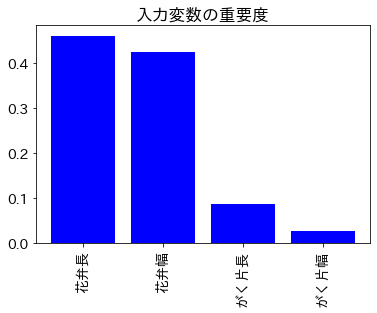

In [25]:
# 重要度の棒グラフ表示

# 棒グラフ表示
plt.bar(range(len(u)), u, color='b', align='center')

# 項目名表示(90度回転)
plt.xticks(range(len(u)), u.index, rotation=90)

# タイトル表示
plt.title('入力変数の重要度')

plt.show()

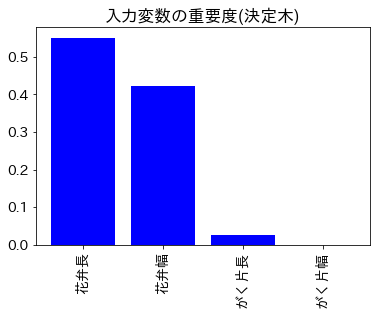

In [26]:
# 決定木の場合

from sklearn.tree import DecisionTreeClassifier
algorism = DecisionTreeClassifier(random_state=random_seed)
algorism.fit(x, y)
importances = algorism.feature_importances_
w = pd.Series(importances, index=x.columns)
u = w.sort_values(ascending=False)
plt.title('入力変数の重要度(決定木)')
plt.bar(range(len(u)), u, color='b', align='center')
plt.xticks(range(len(u)), u.index, rotation=90)
plt.show()

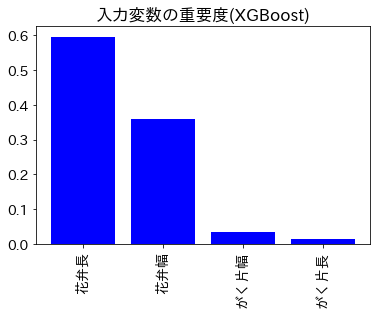

In [27]:
# XGBoostの場合

import xgboost
algorism = xgboost.XGBClassifier(random_state=random_seed)
algorism.fit(x, y)
importances = algorism.feature_importances_
w = pd.Series(importances, index=x.columns)
u = w.sort_values(ascending=False)
plt.title('入力変数の重要度(XGBoost)')
plt.bar(range(len(u)), u, color='b', align='center')
plt.xticks(range(len(u)), u.index, rotation=90)
plt.show()

### 4.4.6 回帰モデルの評価方法

In [28]:
# データ読み込みからデータ分割まで

# データ読み込み(ボストン・データセット)
from sklearn.datasets import load_boston
boston = load_boston()

# df: 入力データ
df = pd.DataFrame(boston.data, columns=boston.feature_names)

# y: 正解データ
y = boston.target

# 1項目だけの入力データ df1を作る
df1 = df[['RM']]

# 結果確認
display(df.head())
display(df1.head())
print(y[:5])

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.0063,18.0000,2.3100,0.0000,0.5380,6.5750,65.2000,4.0900,1.0000,296.0000,15.3000,396.9000,4.9800
1,0.0273,0.0000,7.0700,0.0000,0.4690,6.4210,78.9000,4.9671,2.0000,242.0000,17.8000,396.9000,9.1400
2,0.0273,0.0000,7.0700,0.0000,0.4690,7.1850,61.1000,4.9671,2.0000,242.0000,17.8000,392.8300,4.0300
3,0.0324,0.0000,2.1800,0.0000,0.4580,6.9980,45.8000,6.0622,3.0000,222.0000,18.7000,394.6300,2.9400
4,0.0691,0.0000,2.1800,0.0000,0.4580,7.1470,54.2000,6.0622,3.0000,222.0000,18.7000,396.9000,5.3300


,RM
0,6.5750
1,6.4210
2,7.1850
3,6.9980
4,7.1470


[24.  21.6 34.7 33.4 36.2]


In [29]:
# アルゴリズム選定から予測まで

# アルゴリズム: XGBRegressor
from xgboost import XGBRegressor
algorism1 = XGBRegressor(objective ='reg:squarederror',
    random_state=random_seed)

# 学習 (入力データにdf1を利用)
algorism1.fit(df1, y)

# 予測
y_pred1 = algorism1.predict(df1)


# アルゴリズム: XGBRegressor
from xgboost import XGBRegressor
algorism2 = XGBRegressor(objective ='reg:squarederror',
    random_state=random_seed)

# 学習 (入力データにdfを利用)
algorism2.fit(df, y)

# 予測
y_pred2 = algorism2.predict(df)

In [30]:
# 結果確認
print(f'y[:5] {y[:5]}')
print(f'y_pred1[:5] {y_pred1[:5]}')
print(f'y_pred2[:5] {y_pred2[:5]}')

y[:5] [24.  21.6 34.7 33.4 36.2]
y_pred1[:5] [25.438  20.3028 33.6333 31.4608 33.9829]
y_pred2[:5] [26.6479 22.2483 34.0721 34.315  35.4908]


In [31]:
# yの最大値と最小値の計算
y_range = np.array([y.min(), y.max()])

# 結果確認
print(y_range)

[ 5. 50.]


#### 散布図表示

#### 1入力変数の場合

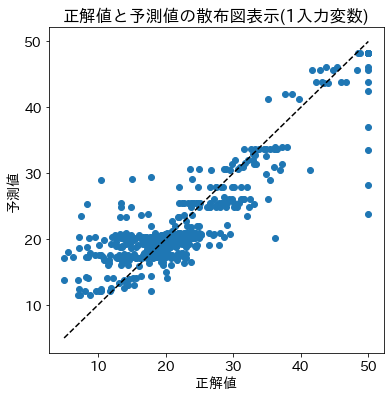

In [32]:
# 散布図による結果確認(1入力変数)

# 描画サイズ指定
plt.figure(figsize=(6,6))

# 散布図
plt.scatter(y, y_pred1)

# 正解データ=予測結果の直線
plt.plot(y_range, y_range, 'k--')

# ラベル・タイトル
plt.xlabel('正解データ')
plt.ylabel('予測結果')
plt.title('正解データと予測結果の散布図表示(1入力変数)')

plt.show()

#### 13入力変数の場合

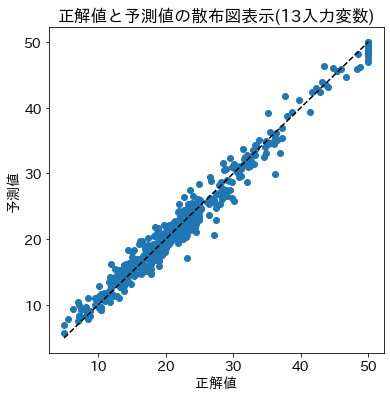

In [33]:
# 散布図による結果確認(13入力変数)

# 描画サイズ指定
plt.figure(figsize=(6,6))

# 散布図
plt.scatter(y, y_pred2)

# 正解データ=予測結果の直線
plt.plot(y_range, y_range, 'k--')

# ラベル・タイトル
plt.xlabel('正解データ')
plt.ylabel('予測結果')
plt.title('正解データと予測結果の散布図表示(13入力変数)')

plt.show()

#### R2 score

In [34]:
# r2 scoreの計算(1入力変数)
from sklearn.metrics import r2_score
r2_score1 = r2_score(y, y_pred1)
print(f'R2 score(1入力変数): {r2_score1:.4f}')

R2 score(1入力変数): 0.7424


In [35]:
# r2 scoreの計算(13入力変数)
r2_score2 = r2_score(y, y_pred2)
print(f'R2 score(13入力変数): {r2_score2:.4f}')

R2 score(13入力変数): 0.9720
